In [27]:
# Import dependencies
import numpy as np
import pandas as pd
import random
from math import comb
from collections import defaultdict
from matplotlib import pyplot as plt
from scipy.interpolate import griddata

In [2]:
# Function for outputting data
def outputData(dataframe, filename):
    '''
    Outputs the given data as a csv file.
    '''
    dataframe.to_csv(filename, index=False) 

In [3]:
# Generate Ballots, Profiles
def createAlternatives(num):
    '''
    Create list with desired number of alternatives. Example: createAlternatives(5) = ['0', '1', '2', '3', '4'].
    '''
    return [str(i) for i in range(num)]


def generateProfile(num_voters, alternatives):
    '''
    Given the number of voters and alternatives, this function returns a profile with each ballot a randomized shuffle of the alternatives.
    '''

    # Initialize empty list for profile
    profile = []

    for i in range(num_voters):
        # For every voter, randomize ranking of alternatives and add to profile
        ballot = random.sample(alternatives, len(alternatives))
        profile.append(ballot)

    return np.array(profile)

# Test profile:
test_alternatives = createAlternatives(4)
test_num_voters = 100
test_profile = generateProfile(test_num_voters, test_alternatives)

In [17]:
# Find Winners
def getBordaWinner(profile):
    '''
    Finds the winner of a given profile (2D numpy array) using the Borda Count: points assigned by rank.
    '''
    # Get num voters, num alternatives
    num_voters, num_alternatives = profile.shape
    
    results = {}
    
    for ballot in profile:
        for rank, alt in enumerate(ballot):
            pts_earned = num_alternatives - (rank+1)
            results[alt] = results.get(alt, 0) + pts_earned
    
    winners = [key for key, value in results.items() if value == max(results.values())]
    return winners

def getCondorcetWinner(profile):
    '''
    Finds the winner of a given profile (2D numpy array) using the Condorcet System: winner if head-to-head winner 
    against every other alternative. Also tracks the number of head-to-head ties.
    '''
    # Get num voters, num alternatives
    num_voters, num_alternatives = profile.shape
    
    # Initialize number of ties
    numTies = 0
    
    alternatives = [str(i) for i in range(num_alternatives)]
    winners = list()

    # Iterate through alternatives to compare to the other ones
    for alt in alternatives:

        # Create list and dictionary of the other choices in order to make comparisons and tracking scores easier
        others = list(set(alternatives) - set([alt]))
        others_scores = defaultdict(int)

        # Iterate through every ballot and compare to the other alternatives
        for diff_alt in others:
            for i in range(len(profile)):

                # index i < index j implies voter prefers i to j
                # if they prefer anything other than current choice, increment value associated with that alternative in dictionary
                if (list(profile[i]).index(alt) > list(profile[i]).index(diff_alt)):
                    others_scores[diff_alt] += 1
                    
        for value in others_scores.values():
            if value == len(profile)/2:
                numTies += 1

        if (all(value <= len(profile)/2 for value in others_scores.values())):
            # If the other choices all got less or equal to half the vote, then current alternative is a Condorcet Winner
            winners.append(alt)

    return winners, numTies/2

def getCoombsWinner(profile):
    '''
    Finds the winner of a given profile (2D numpy array) using the Coombs System: iteratively remove most common
    last-place choice.
    '''
    # Get num voters, num alternatives
    num_voters, num_alternatives = profile.shape

    # Initialize dict to track last place votes
    scores = dict()
    for i in range(num_alternatives):
        scores[i] = 0
        
    eliminated = []

    while True:
        # Get last choice votes, add to score
        for voter in range(num_voters):
            ballot = profile[voter]
            last_choice_ind = -1
            while int(ballot[last_choice_ind]) in eliminated:
                last_choice_ind -= 1
                if last_choice_ind == -(num_alternatives):
                    break
            lastChoice = int(ballot[last_choice_ind])
            scores[lastChoice] = scores.get(lastChoice, 0) + 1

        # Eliminate alternative with most last-place votes
        maxReceived = max(scores.values())
        elim = [key for key in scores.keys() if scores[key] == maxReceived]

        for elimAlt in elim:
            del scores[elimAlt]

        eliminated += elim
        
        if len(eliminated) == num_alternatives:
            return [str(i) for i in elim]
        elif len(eliminated) == num_alternatives - 1:
            return [str(i) for i in [i for i in range(num_alternatives)] if i not in eliminated]
        
def getRCVWinner(profile):
    '''
    Finds the winner of a given profile (2D numpy array) using the Ranked-Choice Voting System: iteratively remove 
    least common first-place choice.
    '''
    # Get num voters, num alternatives
    num_voters, num_alternatives = profile.shape

    # Initialize dict to track last place votes
    scores = dict()
    for i in range(num_alternatives):
        scores[i] = 0
        
    eliminated = []

    while True:
        # Get first choice votes, add to score
        for voter in range(num_voters):
            ballot = profile[voter]
            first_choice_ind = 0
            while int(ballot[first_choice_ind]) in eliminated:
                first_choice_ind += 1
                if first_choice_ind == num_alternatives-1:
                    break
            firstChoice = int(ballot[first_choice_ind])
            scores[firstChoice] = scores.get(firstChoice, 0) + 1

        # Eliminate alternative with fewest votes
        minReceived = min(scores.values())
        elim = [key for key in scores.keys() if scores[key] == minReceived]

        for elimAlt in elim:
            del scores[elimAlt]

        eliminated += elim
        
        if len(eliminated) == num_alternatives:
            return [str(i) for i in elim]
        elif len(eliminated) == num_alternatives - 1:
            return [str(i) for i in [i for i in range(num_alternatives)] if i not in eliminated]


**Borda Count**: Frequency analysis for number of winners

In [60]:
def runBordaFrequencySim(num_sims, num_alternatives, num_voters):
    '''
    Performs the simulation. Returns the frequency at which each number of possible winners occurs.
    '''
    # Track
    numWinners = {}
    
    # Set Dictionary to track how many times each number of winners occurs
    for i in range(num_sims):

        # Create alternatives, then profiles, then determine condorcet winner each time
        alternatives = createAlternatives(num_alternatives)
        profile = generateProfile(num_voters, alternatives)
    
        # Find winner(s)
        winners = getBordaWinner(profile)
        num_winners = len(winners)
        
        numWinners[num_winners] = numWinners.get(num_winners, 0) + 1

    return {key: 1.*value/num_sims for key, value in numWinners.items()}

# House simulation
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

data = []
columns = ["num_voters", "num_alternatives", "unique_winner_frequency", "winner_frequency"] + [str(i)+"_winner_frequency" for i in range(num_alts_max+1)[2:]]
data.append(columns)

# Run simulation for every pair of num_alternatives and num_voters in the given range
for num_alternatives in range(2, num_alts_max+1):
    for num_voters in range(num_voters_min, num_voters_max+1):
        print(num_voters, num_alternatives)
        
        # Get results
        results = runBordaFrequencySim(num_sims, num_alternatives, num_voters)
        
        # Initialize list for data to be entered (eventually will be appended to data)
        row = []

        # Enter results into row
        row.append(num_voters)
        row.append(num_alternatives)
        row.append(float(f'{results.get(1, 0):.4f}'))
        row.append(sum([float(f'{results.get(i, 0):.4f}') for i in range(1, num_alts_max+1)]))
        for i in range(num_alts_max+1)[2:]:
            row.append(float(f'{results.get(i, 0):.4f}'))
        data.append(row)

df = pd.DataFrame(data[1:], columns=data[0])
# outputData(df, "borda_data.csv")

5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2


KeyboardInterrupt: 

/var/folders/3k/b2ln101d1f1fv47bdyyjfwdh0000gn/T/ipykernel_43981/1923887338.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surface, label='Percentage', location="left")


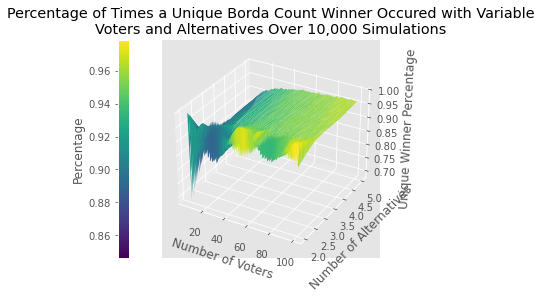

In [61]:
df = pd.read_csv("./borda_data.csv")

# Create X, Y, and Z coordinates
X = df['num_voters']
Y = df['num_alternatives']
Z = df['unique_winner_frequency']

# Define the regular grid for the 3D surface plot
X_interp = np.linspace(X.min(), X.max(), 100)
Y_interp = np.linspace(Y.min(), Y.max(), 100)
X_interp, Y_interp = np.meshgrid(X_interp, Y_interp)

# Interpolate the Z values onto the regular grid
Z_interp = griddata((X, Y), Z, (X_interp, Y_interp), method='cubic')

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X_interp, Y_interp, Z_interp, cmap='viridis')

# Add labels and a color bar
ax.set_title("Percentage of Times a Unique Borda Count Winner Occured with Variable\nVoters and Alternatives Over 10,000 Simulations")
ax.set_xlabel('Number of Voters')
ax.set_ylabel('Number of Alternatives')
ax.set_zlabel('Unique Winner Percentage')
fig.colorbar(surface, label='Percentage', location="left")
plt.show()

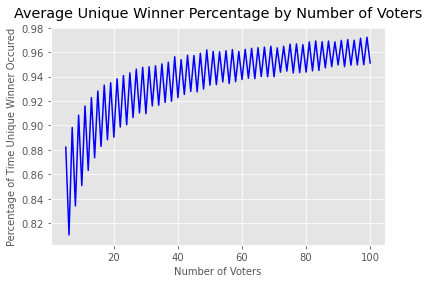

In [188]:
df = pd.read_csv("./borda_data.csv")

# Average unique winner percentage by num_voters

avgWinnerPctByVoters = []
for i in range(2, 101):
    df_ = df.loc[df['num_voters'] == i]
    avgWinnerPctByVoters.append(df_['unique_winner_frequency'].mean())

plt.plot([i for i in range(2, 101)], avgWinnerPctByVoters, c="b")
plt.title("Average Unique Winner Percentage by Number of Voters", pad=10)
plt.xlabel("Number of Voters", fontsize=10)
plt.ylabel("Percentage of Time Unique Winner Occured", fontsize=10)
plt.savefig('./images/UniqueWinnerPercentageByNumVoters.jpg', bbox_inches='tight')
plt.show()

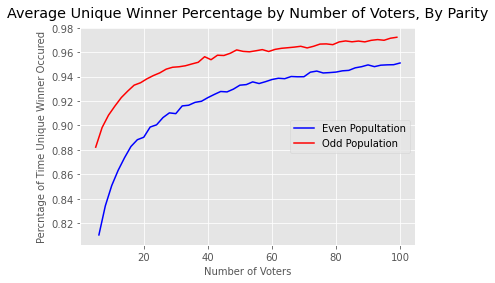

Overall Unique Winner Percentage:  0.9370932291666664
Even Population Unique Winner Percentage:  0.9214567708333333
Odd Population Unique Winner Percentage:  0.9527296874999996


In [187]:
df = pd.read_csv("./borda_data.csv")

# Even Odd Num Voters Analysis

evenDf = df.loc[df['num_voters'] % 2 == 0]
oddDf = df.loc[df['num_voters'] % 2 == 1]
evenWinPct = []
oddWinPct = []

for i in range(2, 101, 2):
    df_ = evenDf.loc[evenDf['num_voters'] == i]
    evenWinPct.append(df_['unique_winner_frequency'].mean())

for i in range(3, 101, 2):
    df_ = oddDf.loc[oddDf['num_voters'] == i]
    oddWinPct.append(df_['unique_winner_frequency'].mean())

plt.plot([i for i in range(2, 101, 2)], evenWinPct,
         c='b', label="Even Popultation")
plt.plot([i for i in range(3, 101, 2)],
         oddWinPct, c='r', label="Odd Population")
plt.legend(loc="center right")
plt.title("Average Unique Winner Percentage by Number of Voters, By Parity", pad=10)
plt.xlabel("Number of Voters", fontsize=10)
plt.ylabel("Percntage of Time Unique Winner Occured", fontsize=10)
plt.savefig('./images/UniqueWinnerPercentageByNumVotersParity.jpg', bbox_inches='tight')
plt.show()

### Aggregate Numbers ###

print("Overall Unique Winner Percentage: ",
      df["unique_winner_frequency"].mean())  # 94.16492704826039
print("Even Population Unique Winner Percentage: ",
      evenDf["unique_winner_frequency"].mean())  # 93.26791111111111
print("Odd Population Unique Winner Percentage: ",
      oddDf["unique_winner_frequency"].mean())  # 95.08024943310658

**Condorcet Method**: Parity Analysis on Likelihood of Ties

In [ ]:
def runCondorcetFrequencySim(num_sims, num_alternatives, num_voters):
    '''
    Performs the simulation. Returns the winner frequencies and the frequency at which ties occur.
    '''
    
    # Track
    numTies = 0
    numWinners = {}
    numComparisons = comb(num_alternatives, 2)
    
    # Set Dictionary to track how many times each number of winners occurs
    for i in range(num_sims):

        # Create alternatives, then profiles, then determine condorcet winner each time
        alternatives = createAlternatives(num_alternatives)
        profile = generateProfile(num_voters, alternatives)
    
        # Find winner(s)
        winners, num_ties = getCondorcetWinner(profile)
        
        num_winners = len(winners)
        
        numWinners[num_winners] = numWinners.get(num_winners, 0) + 1
        numTies += num_ties
    
    tie_frequency = (numTies/num_sims)/numComparisons
    
    return {key: 1.*value/num_sims for key, value in numWinners.items()}, tie_frequency
runCondorcetFrequencySim(10, 2, 4)

# House simulation
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

data = []
columns = ["num_voters", "num_alternatives", "unique_winner_frequency", "winner_frequency"] + [str(i)+"_winner_frequency" for i in range(num_alts_max+1)[2:]] + ["tie_frequency"]
data.append(columns)

# Run simulation for every pair of num_alternatives and num_voters in the given range
for num_alternatives in range(2, num_alts_max+1):
    for num_voters in range(num_voters_min, num_voters_max+1):
        print(num_voters, num_alternatives)
        
        # Get results
        results, tie_freq = runCondorcetFrequencySim(num_sims, num_alternatives, num_voters)
        
        # Initialize list for data to be entered (eventually will be appended to data)
        row = []

        # Enter results into row
        row.append(num_voters)
        row.append(num_alternatives)
        row.append(float(f'{results.get(1, 0):.4f}'))
        row.append(float(f'{sum([results.get(i, 0) for i in range(1, num_alts_max+1)]):.4f}'))
        for i in range(num_alts_max+1)[2:]:
            row.append(float(f'{results.get(i, 0):.4f}'))
        row.append(float(f'{tie_freq:.4f}'))
        
        data.append(row)

df = pd.DataFrame(data[1:], columns=data[0])
# outputData(df, "condorcet_data.csv")

/var/folders/3k/b2ln101d1f1fv47bdyyjfwdh0000gn/T/ipykernel_43981/1315403269.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surface, label='Percentage', location="left")


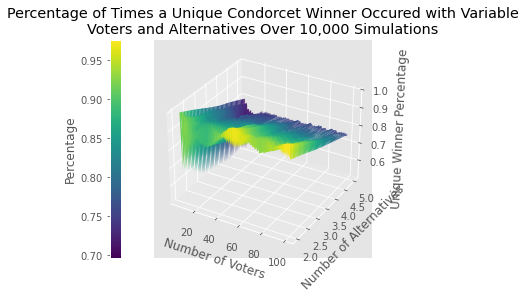

In [196]:
df = pd.read_csv("./condorcet_data.csv")

# Create X, Y, and Z coordinates
X = df['num_voters']
Y = df['num_alternatives']
Z = df['unique_winner_frequency']

# Define the regular grid for the 3D surface plot
X_interp = np.linspace(X.min(), X.max(), 100)
Y_interp = np.linspace(Y.min(), Y.max(), 100)
X_interp, Y_interp = np.meshgrid(X_interp, Y_interp)

# Interpolate the Z values onto the regular grid
Z_interp = griddata((X, Y), Z, (X_interp, Y_interp), method='cubic')

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X_interp, Y_interp, Z_interp, cmap='viridis')

# Add labels and a color bar
ax.set_title("Percentage of Times a Unique Condorcet Winner Occured with Variable\nVoters and Alternatives Over 10,000 Simulations")
ax.set_xlabel('Number of Voters')
ax.set_ylabel('Number of Alternatives')
ax.set_zlabel('Unique Winner Percentage')
fig.colorbar(surface, label='Percentage', location="left")
plt.show()

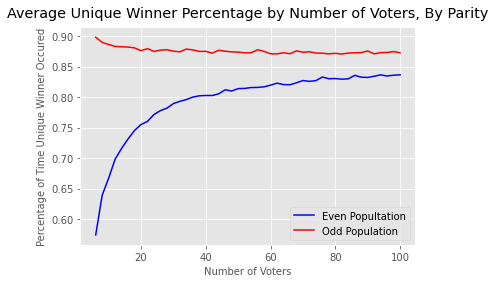

In [206]:
df = pd.read_csv("./condorcet_data.csv")
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

# Even vs. Odd unique winner percentage
evenDf = df.loc[df['num_voters'] % 2 == 0]
oddDf = df.loc[df['num_voters'] % 2 == 1]
evenWinPct = []
oddWinPct = []

for i in range(num_voters_min+1, num_voters_max+1, 2):
    df_ = evenDf.loc[evenDf['num_voters'] == i]
    evenWinPct.append(df_['unique_winner_frequency'].mean())

for i in range(num_voters_min, num_voters_max+1, 2):
    df_ = oddDf.loc[oddDf['num_voters'] == i]
    oddWinPct.append(df_['unique_winner_frequency'].mean())

plt.plot([i for i in range(num_voters_min+1, num_voters_max+1, 2)], evenWinPct,
         c='b', label="Even Popultation")
plt.plot([i for i in range(num_voters_min+1, num_voters_max+1, 2)],
         oddWinPct, c='r', label="Odd Population")
plt.legend(loc="lower right")
plt.title("Average Unique Winner Percentage by Number of Voters, By Parity", pad=10)
plt.xlabel("Number of Voters", fontsize=10)
plt.ylabel("Percentage of Time Unique Winner Occured", fontsize=10)
plt.savefig('./images/CondorcetUniqueWinnerByNumVotersParity.jpg', bbox_inches='tight')
plt.show()

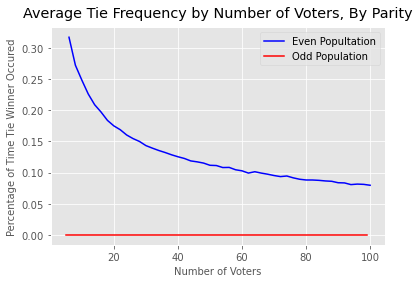

In [208]:
# Even vs. Odd tie percentage by number of voters
evenDf = df.loc[df['num_voters'] % 2 == 0]
oddDf = df.loc[df['num_voters'] % 2 == 1]
evenTiePct = []
oddTiePct = []

for i in range(num_voters_min+1, num_voters_max+1, 2):
    df_ = evenDf.loc[evenDf['num_voters'] == i]
    evenTiePct.append(df_['tie_frequency'].mean())

for i in range(num_voters_min, num_voters_max+1, 2):
    df_ = oddDf.loc[oddDf['num_voters'] == i]
    oddTiePct.append(df_['tie_frequency'].mean())

plt.plot([i for i in range(num_voters_min+1, num_voters_max+1, 2)], evenTiePct,
         c='b', label="Even Popultation")
plt.plot([i for i in range(num_voters_min, num_voters_max+1, 2)],
         oddTiePct, c='r', label="Odd Population")
plt.legend(loc="upper right")
plt.title("Average Tie Frequency by Number of Voters, By Parity", pad=10)
plt.xlabel("Number of Voters", fontsize=10)
plt.ylabel("Percentage of Time Tie Winner Occured", fontsize=10)
plt.savefig('./images/CondorcetTieFrequencyByNumVotersParity.jpg', bbox_inches='tight')
plt.show()

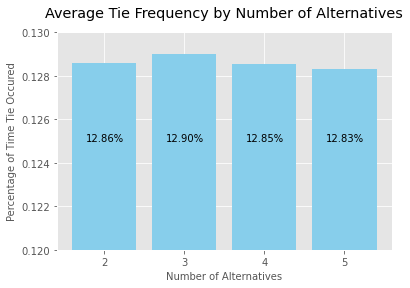

In [209]:
# tie percentage by number of alternatives
tie_freqs = []

dfEven = df[df["num_voters"]%2==0]

for i in range(2, num_alts_max+1):
    df_ = dfEven.loc[df['num_alternatives'] == i]
    tie_freqs.append(df_['tie_frequency'].mean())

plt.bar(x=[i for i in range(2, num_alts_max+1)], height=tie_freqs, color="skyblue")
plt.title("Average Tie Frequency by Number of Alternatives", pad=15)
plt.xlabel("Number of Alternatives", fontsize=10)
plt.ylabel("Percentage of Time Tie Occured", fontsize=10)
plt.xticks([i for i in range(2, num_alts_max+1)], [str(i) for i in range(2, num_alts_max+1)])
plt.ylim((.12, .13))
for i, num_alts in enumerate(range(2, num_alts_max+1)):
        plt.annotate(f'{tie_freqs[i]*100:.2f}%', (num_alts-.23,.125))
plt.savefig('./images/CondorcetTieFrequencyByAlterantives.jpg', bbox_inches='tight')
plt.show()

**Coombs vs. RCV**: Comparison of Coombs and RCV for efficiency, unique winner, etc.

In [102]:
def runCoombsFrequencySim(num_sims, num_alternatives, num_voters):
    '''
    Performs the simulation. Returns the frequency at winners occur.
    '''
    # Track
    numWinners = {}
    
    # Set Dictionary to track how many times each number of winners occurs
    for i in range(num_sims):

        # Create alternatives, then profiles, then determine condorcet winner each time
        alternatives = createAlternatives(num_alternatives)
        profile = generateProfile(num_voters, alternatives)
    
        # Find winner(s)
        winners = getCoombsWinner(profile)
        num_winners = len(winners)
        
        numWinners[num_winners] = numWinners.get(num_winners, 0) + 1

    return {key: 1.*value/num_sims for key, value in numWinners.items()}

# House simulation
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

data = []
columns = ["num_voters", "num_alternatives", "unique_winner_frequency", "winner_frequency"] + [str(i)+"_winner_frequency" for i in range(num_alts_max+1)[2:]]
data.append(columns)

# Run simulation for every pair of num_alternatives and num_voters in the given range
for num_alternatives in range(2, num_alts_max+1):
    for num_voters in range(num_voters_min, num_voters_max+1):
        print(num_voters, num_alternatives)
        
        # Get results
        results = runCoombsFrequencySim(num_sims, num_alternatives, num_voters)
        
        # Initialize list for data to be entered (eventually will be appended to data)
        row = []

        # Enter results into row
        row.append(num_voters)
        row.append(num_alternatives)
        row.append(float(f'{results.get(1, 0):.4f}'))
        row.append(sum([float(f'{results.get(i, 0):.4f}') for i in range(1, num_alts_max+1)]))
        for i in range(num_alts_max+1)[2:]:
            row.append(float(f'{results.get(i, 0):.4f}'))
        data.append(row)

df = pd.DataFrame(data[1:], columns=data[0])
# outputData(df, "coombs_data.csv")

5 2
6 2
7 2
8 2
9 2
10 2


In [105]:
def runRCVFrequencySim(num_sims, num_alternatives, num_voters):
    '''
    Performs the simulation. Returns the frequency at winners occur.
    '''
    # Track
    numWinners = {}
    
    # Set Dictionary to track how many times each number of winners occurs
    for i in range(num_sims):

        # Create alternatives, then profiles, then determine condorcet winner each time
        alternatives = createAlternatives(num_alternatives)
        profile = generateProfile(num_voters, alternatives)
    
        # Find winner(s)
        winners = getRCVWinner(profile)
        num_winners = len(winners)
        
        numWinners[num_winners] = numWinners.get(num_winners, 0) + 1

    return {key: 1.*value/num_sims for key, value in numWinners.items()}

# House simulation
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

data = []
columns = ["num_voters", "num_alternatives", "unique_winner_frequency", "winner_frequency"] + [str(i)+"_winner_frequency" for i in range(num_alts_max+1)[2:]]
data.append(columns)

# Run simulation for every pair of num_alternatives and num_voters in the given range
for num_alternatives in range(2, num_alts_max+1):
    for num_voters in range(num_voters_min, num_voters_max+1):
        print(num_voters, num_alternatives)
        
        # Get results
        results = runRCVFrequencySim(num_sims, num_alternatives, num_voters)
        
        # Initialize list for data to be entered (eventually will be appended to data)
        row = []

        # Enter results into row
        row.append(num_voters)
        row.append(num_alternatives)
        row.append(float(f'{results.get(1, 0):.4f}'))
        row.append(sum([float(f'{results.get(i, 0):.4f}') for i in range(1, num_alts_max+1)]))
        for i in range(num_alts_max+1)[2:]:
            row.append(float(f'{results.get(i, 0):.4f}'))
        data.append(row)

df = pd.DataFrame(data[1:], columns=data[0])
outputData(df, "RCV_data.csv")

5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
5 4
6 4
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 4
15 

/var/folders/3k/b2ln101d1f1fv47bdyyjfwdh0000gn/T/ipykernel_43981/567642838.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surface, label='Percentage', location="left")


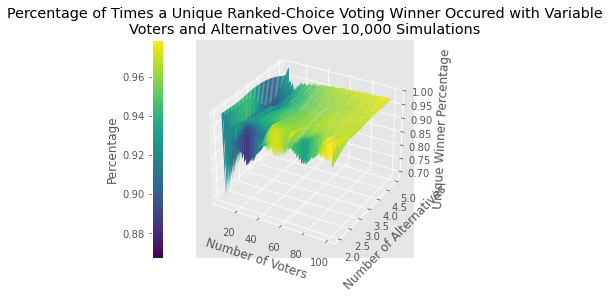

In [108]:
df = pd.read_csv("./RCV_data.csv")

# Create X, Y, and Z coordinates
X = df['num_voters']
Y = df['num_alternatives']
Z = df['unique_winner_frequency']

# Define the regular grid for the 3D surface plot
X_interp = np.linspace(X.min(), X.max(), 100)
Y_interp = np.linspace(Y.min(), Y.max(), 100)
X_interp, Y_interp = np.meshgrid(X_interp, Y_interp)

# Interpolate the Z values onto the regular grid
Z_interp = griddata((X, Y), Z, (X_interp, Y_interp), method='cubic')

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X_interp, Y_interp, Z_interp, cmap='viridis')

# Add labels and a color bar
ax.set_title("Percentage of Times a Unique Ranked-Choice Voting Winner Occured with Variable\nVoters and Alternatives Over 10,000 Simulations")
ax.set_xlabel('Number of Voters')
ax.set_ylabel('Number of Alternatives')
ax.set_zlabel('Unique Winner Percentage')
fig.colorbar(surface, label='Percentage', location="left")
plt.show()

/var/folders/3k/b2ln101d1f1fv47bdyyjfwdh0000gn/T/ipykernel_43981/1832841467.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surface, label='Percentage', location="left")


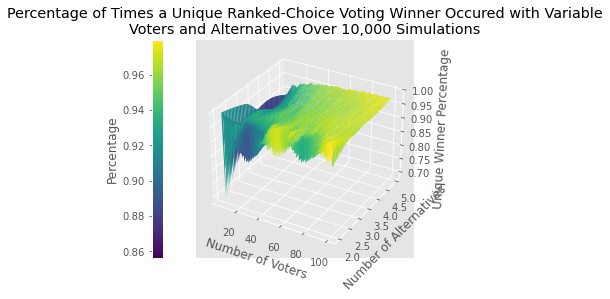

In [109]:
df = pd.read_csv("./coombs_data.csv")

# Create X, Y, and Z coordinates
X = df['num_voters']
Y = df['num_alternatives']
Z = df['unique_winner_frequency']

# Define the regular grid for the 3D surface plot
X_interp = np.linspace(X.min(), X.max(), 100)
Y_interp = np.linspace(Y.min(), Y.max(), 100)
X_interp, Y_interp = np.meshgrid(X_interp, Y_interp)

# Interpolate the Z values onto the regular grid
Z_interp = griddata((X, Y), Z, (X_interp, Y_interp), method='cubic')

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X_interp, Y_interp, Z_interp, cmap='viridis')

# Add labels and a color bar
ax.set_title("Percentage of Times a Unique Ranked-Choice Voting Winner Occured with Variable\nVoters and Alternatives Over 10,000 Simulations")
ax.set_xlabel('Number of Voters')
ax.set_ylabel('Number of Alternatives')
ax.set_zlabel('Unique Winner Percentage')
fig.colorbar(surface, label='Percentage', location="left")
plt.show()

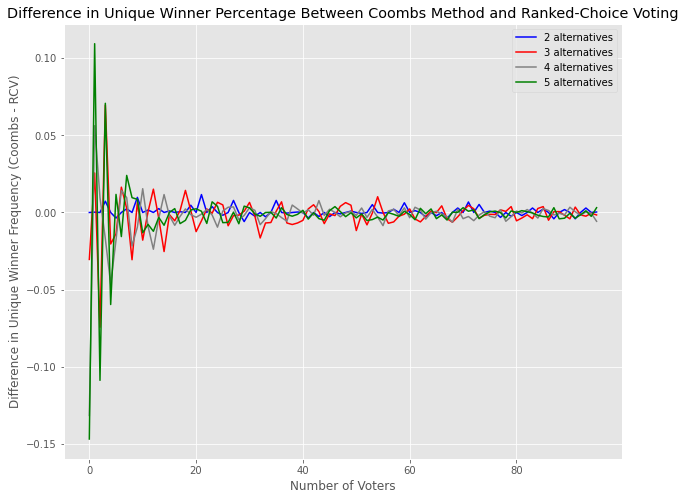

In [210]:
# difference in coombs vs rcv
coombs_df = pd.read_csv('./coombs_data.csv')
rcv_df = pd.read_csv('./RCV_data.csv')

plt.figure(figsize=(10,8))
colors = ['blue', 'red', 'grey', 'green']

for i, num_alts in enumerate(range(2, num_alts_max+1)):
    coombs_df_ = coombs_df[coombs_df['num_alternatives']==num_alts]
    rcv_df_ = rcv_df[rcv_df['num_alternatives']==num_alts]
    diff = coombs_df_.unique_winner_frequency - rcv_df_.unique_winner_frequency
    plt.plot([a-(i*96) for a in diff.index], diff.values, color=colors[i % len(colors)], label=f'{num_alts} alternatives')
plt.title("Difference in Unique Winner Percentage Between Coombs Method and Ranked-Choice Voting")
plt.xlabel("Number of Voters")
plt.ylabel("Difference in Unique Winner Frequency (Coombs - RCV)")
plt.legend(loc="upper right")
plt.savefig('./images/CoombsRCVDiffUniqueWinnerPercentage.jpg', bbox_inches='tight')
plt.show()

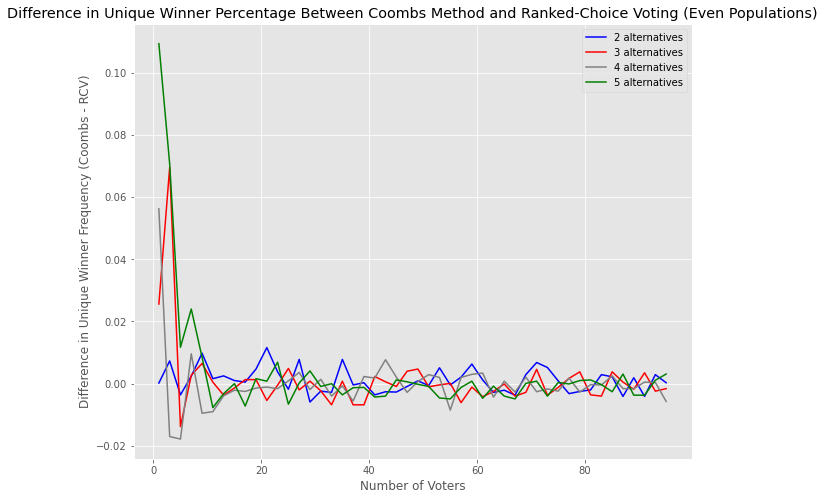

In [211]:
coombs_df_even = coombs_df[coombs_df['num_voters']%2==0]
rcv_df_even = rcv_df[rcv_df['num_voters']%2==0]

plt.figure(figsize=(10,8))
colors = ['blue', 'red', 'grey', 'green']

for i, num_alts in enumerate(range(2, num_alts_max+1)):
    coombs_df_ = coombs_df_even[coombs_df_even['num_alternatives']==num_alts]
    rcv_df_ = rcv_df_even[rcv_df_even['num_alternatives']==num_alts]
    diff = coombs_df_.unique_winner_frequency - rcv_df_.unique_winner_frequency
    plt.plot([a-(i*96) for a in diff.index], diff.values, color=colors[i % len(colors)], label=f'{num_alts} alternatives')
plt.title("Difference in Unique Winner Percentage Between Coombs Method and Ranked-Choice Voting (Even Populations)")
plt.xlabel("Number of Voters")
plt.ylabel("Difference in Unique Winner Frequency (Coombs - RCV)")
plt.legend(loc="upper right")
plt.savefig('./images/CoombsRCVDiffUniqueWinnerPercentageEven.jpg', bbox_inches='tight')
plt.show()

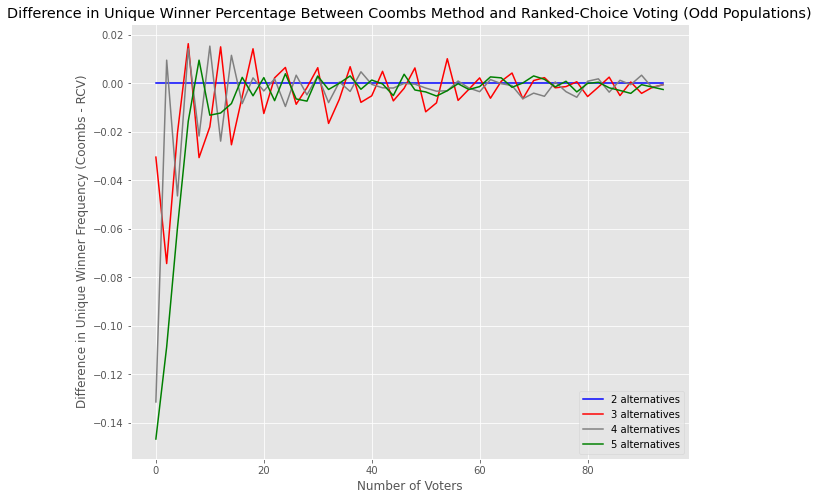

In [212]:
coombs_df_odd = coombs_df[coombs_df['num_voters']%2==1]
rcv_df_odd = rcv_df[rcv_df['num_voters']%2==1]

plt.figure(figsize=(10,8))
colors = ['blue', 'red', 'grey', 'green']

for i, num_alts in enumerate(range(2, num_alts_max+1)):
    coombs_df_ = coombs_df_odd[coombs_df_odd['num_alternatives']==num_alts]
    rcv_df_ = rcv_df_odd[rcv_df_odd['num_alternatives']==num_alts]
    diff = coombs_df_.unique_winner_frequency - rcv_df_.unique_winner_frequency
    plt.plot([a-(i*96) for a in diff.index], diff.values, color=colors[i % len(colors)], label=f'{num_alts} alternatives')
plt.title("Difference in Unique Winner Percentage Between Coombs Method and Ranked-Choice Voting (Odd Populations)")
plt.xlabel("Number of Voters")
plt.ylabel("Difference in Unique Winner Frequency (Coombs - RCV)")
plt.legend(loc="lower right")
plt.savefig('./images/CoombsRCVDiffUniqueWinnerPercentageOdd.jpg', bbox_inches='tight')
plt.show()

In [140]:
def runRCVvsCoombsFrequencySim(num_sims, num_alternatives, num_voters):
    '''
    Performs the simulation. Returns the frequency at which winners match from Coombs to RCV.
    '''
    num_identical_winners = 0
    num_same_num_winners = 0
    
    # Set Dictionary to track how many times each number of winners occurs
    for i in range(num_sims):

        # Create alternatives, then profiles, then determine condorcet winner each time
        alternatives = createAlternatives(num_alternatives)
        profile = generateProfile(num_voters, alternatives)
    
        # Find winner(s)
        rcv_winners = getRCVWinner(profile)
        coombs_winners = getCoombsWinner(profile)
        
        if set(rcv_winners) == set(coombs_winners):
            num_identical_winners += 1
            
        if len(rcv_winners) == len(coombs_winners):
            num_same_num_winners += 1

    return num_identical_winners/num_sims, num_same_num_winners/num_sims

# House simulation
num_sims = 10000
num_alts_max = 5
num_voters_min = 5
num_voters_max = 100

data = []
columns = ["num_voters", "num_alternatives", "identical_winners_frequency", "same_number_of_winners_frequency"]
data.append(columns)

# Run simulation for every pair of num_alternatives and num_voters in the given range
for num_alternatives in range(2, num_alts_max+1):
    for num_voters in range(num_voters_min, num_voters_max+1):
        print(num_voters, num_alternatives)
        
        # Get results
        identical_rate, same_num_rate = runRCVvsCoombsFrequencySim(num_sims, num_alternatives, num_voters)
        
        # Initialize list for data to be entered (eventually will be appended to data)
        row = []

        # Enter results into row
        row.append(num_voters)
        row.append(num_alternatives)
        row.append(identical_rate)
        row.append(same_num_rate)
        data.append(row)

df = pd.DataFrame(data[1:], columns=data[0])
outputData(df, "RCV_coombs_data.csv")

5 2
6 2
7 2
8 2
9 2
10 2


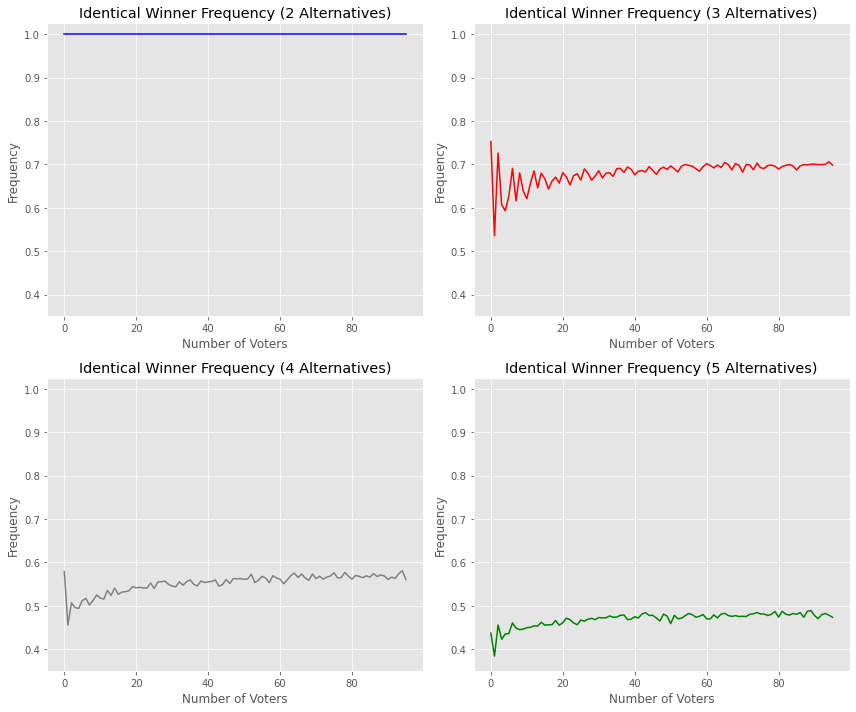

In [214]:
df = pd.read_csv("./RCV_coombs_data.csv")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
colors = ['blue', 'red', 'grey', 'green']

for i, num_alts in enumerate(range(2, num_alts_max + 1)):
    # Select data
    df_ = df[df['num_alternatives'] == num_alts]
    
    # Plot 
    ax = axs[i // 2, i % 2]
    ax.plot([a-(i*96) for a in df_.index], df_.identical_winners_frequency, color=colors[i % len(colors)])
    ax.set_title(f'Identical Winner Frequency ({num_alts} Alternatives)')
    ax.set_ylim(.35,1.025)
    ax.set_xlabel("Number of Voters")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.savefig('./images/CoombsRCVIdenticalWinnerFrequency.jpg', bbox_inches='tight')
plt.show()

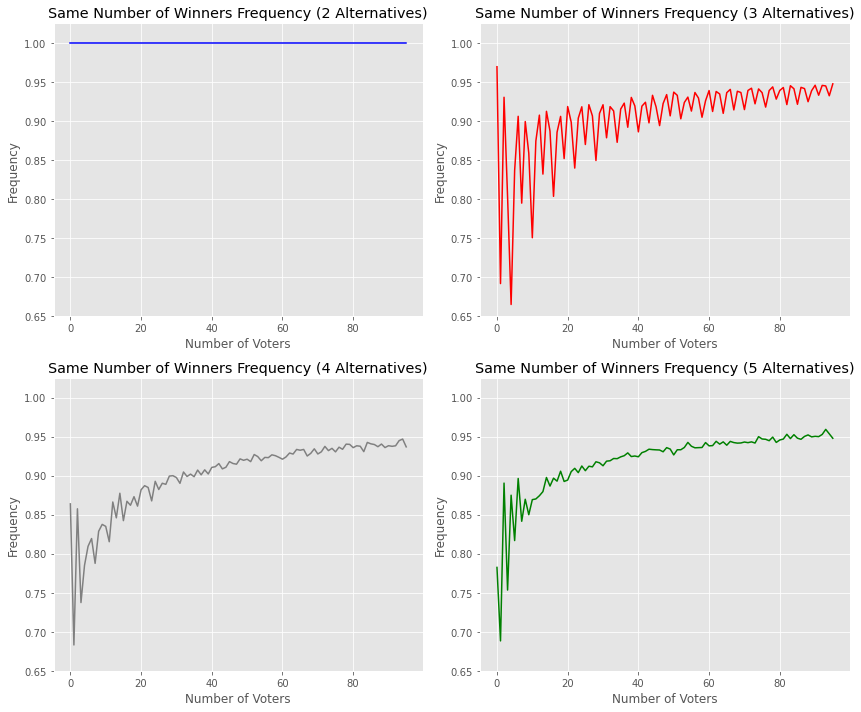

In [181]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
colors = ['blue', 'red', 'grey', 'green']

for i, num_alts in enumerate(range(2, num_alts_max + 1)):
    # Select data
    df_ = df[df['num_alternatives'] == num_alts]
    
    # Plot 
    ax = axs[i // 2, i % 2]
    ax.plot([a-(i*96) for a in df_.index], df_.same_number_of_winners_frequency, color=colors[i % len(colors)])
    ax.set_title(f'Same Number of Winners Frequency ({num_alts} Alternatives)')
    ax.set_ylim(.65,1.025)
    ax.set_xlabel("Number of Voters")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()